In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from six.moves import cPickle as pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Dropout, Conv1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, concatenate, MaxPooling1D

%matplotlib inline

In [0]:
def getFileRoutes(folder_routes):
    file_routes = []

    for folder_name in os.listdir(folder_routes):
        folder_route = os.path.join(folder_routes, folder_name)
        if os.path.isdir(folder_route):
            for file_name in os.listdir(folder_route):
                file_route = os.path.join(folder_route, file_name)
                file_routes.append(file_route)

    return file_routes

In [0]:
def cleanString(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    
    string = str(string)
    
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    return string.strip().lower()

In [0]:
def getTruthfulAndDeceptiveReviewRoutes():
    truthful_review_routes = []
    deceptive_review_routes = []

    truthful_review_routes.extend(getFileRoutes(TRUTHFUL_POSITIVE_FOLDER_ROUTES))
    truthful_review_routes.extend(getFileRoutes(TRUTHFUL_NEGATIVE_FOLDER_ROUTES))
    deceptive_review_routes.extend(getFileRoutes(DECEPTIVE_POSITIVE_FOLDER_ROUTES))
    deceptive_review_routes.extend(getFileRoutes(DECEPTIVE_NEGATIVE_FOLDER_ROUTES))

    return truthful_review_routes, deceptive_review_routes

In [0]:
def getAllReviewFromRoutes(all_review_routes):
    reviews = []

    for file_route in all_review_routes:
        with open(file_route, "r") as file_object:
            cleaned_text = cleanString(file_object.readlines())
            reviews.append(cleaned_text)

    return reviews

In [0]:
def loadWord2VecModel(trimmed_word_2_vec_model_file_route, save_key):
    with open(trimmed_word_2_vec_model_file_route, 'rb') as pickle_file :
        save = pickle.load(pickle_file)
        trimmed_word_2_vec_model = save[save_key]

    del save

    return trimmed_word_2_vec_model

In [0]:
def createCNNModel():
    input_layer = Input(shape = (160,))
    embedding_layer = Embedding(vocabulary_size, WORD_EMBEDDING_VECTOR_SIZE, weights = [word_2_vec_model], trainable = False, input_length = MAX_WORD_COUNT_PER_SENTENCE)(input_layer)
    reshape_to_sentences = Reshape((16, 10, 300))(embedding_layer)

    sentence_conv_1 = Conv2D(100, (1, 3))(reshape_to_sentences)
    sentence_maxpool_1 = MaxPooling2D((1, 8))(sentence_conv_1)
    sentence_activation_1 = Activation('tanh')(sentence_maxpool_1)

    sentence_conv_2 = Conv2D(100, (1, 4))(reshape_to_sentences)
    sentence_maxpool_2 = MaxPooling2D((1, 7))(sentence_conv_2)
    sentence_activation_2 = Activation('tanh')(sentence_maxpool_2)

    sentence_conv_3 = Conv2D(100, (1, 5))(reshape_to_sentences)
    sentence_maxpool_3 = MaxPooling2D((1, 6))(sentence_conv_3)
    sentence_activation_3 = Activation('tanh')(sentence_maxpool_3)

    sentence_concatenate = concatenate([sentence_activation_1, sentence_activation_2, sentence_activation_3])
    sentence_reshape = Reshape((16, 300))(sentence_concatenate)
    sentence_dropout = Dropout(0.5)(sentence_reshape)

    document_conv_1 = Conv1D(100, (3))(sentence_dropout)
    document_maxpool_1 = MaxPooling1D((14))(document_conv_1)
    document_activation_1 = Activation('tanh')(document_maxpool_1)

    document_conv_2 = Conv1D(100, (4))(sentence_dropout)
    document_maxpool_2 = MaxPooling1D((13))(document_conv_2)
    document_activation_2 = Activation('tanh')(document_maxpool_2)

    document_conv_3 = Conv1D(100, (5))(sentence_dropout)
    document_maxpool_3 = MaxPooling1D((12))(document_conv_3)
    document_activation_3 = Activation('tanh')(document_maxpool_3)

    document_concatenate = concatenate([document_activation_1, document_activation_2, document_activation_3])
    document_reshape = Reshape((300,))(document_concatenate)
    document_dropout = Dropout(0.5)(document_reshape)

    output_layer = Dense(2, activation = 'softmax')(document_dropout)

    model = Model(inputs = input_layer, outputs = output_layer)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [0]:
def saveDataUsingPickle(file_route, data):
    try:
        with open(file_route, "wb") as file_object:
            pickle.dump(data, file_object, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to ', file_route, ': ', e)
        raise

    fileInformation = os.stat(file_route)
    print('Compressed pickle size of', file_route, 'in Bytes:', fileInformation.st_size)

In [0]:
TRUTHFUL_POSITIVE_FOLDER_ROUTES = '/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/gold_standard_dataset/positive_polarity/truthful_from_TripAdvisor/'
TRUTHFUL_NEGATIVE_FOLDER_ROUTES = '/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/gold_standard_dataset/negative_polarity/truthful_from_Web/'
DECEPTIVE_POSITIVE_FOLDER_ROUTES = '/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/gold_standard_dataset/positive_polarity/deceptive_from_MTurk/'
DECEPTIVE_NEGATIVE_FOLDER_ROUTES = '/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/gold_standard_dataset/negative_polarity/deceptive_from_MTurk/'

"""
    NOTE: Truthful and Deceptive Labeling Style
    Truthful is labelled [1, 0] hence argmax would return 0
    Deceptive is labelled [0, 1] hence argmax would return 1
    (18/3/2020) Aflah Nadhif
"""
TRUTHFUL_REVIEW_LABEL = [1, 0]
DECEPTIVE_REVIEW_LABEL = [0, 1]

WORD_EMBEDDING_VECTOR_SIZE = 300
MAX_WORD_COUNT_PER_SENTENCE = 160
CLASSIFICATION_CATEGORY = 2

In [0]:
truthful_review_routes, deceptive_review_routes = getTruthfulAndDeceptiveReviewRoutes()
all_review_routes = truthful_review_routes + deceptive_review_routes

reviews = getAllReviewFromRoutes(all_review_routes)

review_count = len(all_review_routes)

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
vocabulary_size = len(tokenizer.word_index) + 1

encoded_reviews = tokenizer.texts_to_sequences(reviews)
padded_encoded_reviews = pad_sequences(encoded_reviews, maxlen = MAX_WORD_COUNT_PER_SENTENCE, padding = 'post')

labels = np.ndarray(shape = (review_count, CLASSIFICATION_CATEGORY), dtype = 'int32')
labels[0:len(truthful_review_routes)] = np.array(TRUTHFUL_REVIEW_LABEL)
labels[len(deceptive_review_routes):review_count] = np.array(DECEPTIVE_REVIEW_LABEL)

In [14]:
pickle_file_route = '/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/trained_model/tokenizer/tokenizer.pickle'
save_data = {'tokenizer': tokenizer}

saveDataUsingPickle(pickle_file_route, save_data)

Compressed pickle size of /content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/trained_model/tokenizer/tokenizer.pickle in Bytes: 388580


In [0]:
'''
    HACK: Data Splitting Percentage
    Train data is 60%
    Validation data is 60%
    Test data is 20%
    (23/3/2020) Aflah Nadhif Hammam
'''
X_train_val, X_test, y_train_val, y_test = train_test_split(padded_encoded_reviews, labels, test_size = 0.2)

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 9s 10ms/sample - loss: 1.0222 - acc: 0.5010 - val_loss: 1.0088 - val_acc: 0.4656
Epoch 2/100
960/960 [==============================] - 7s 7ms/sample - loss: 0.9029 - acc: 0.5156 - val_loss: 0.6973 - val_acc: 0.5344
Epoch 3/100
960/960 [==============================] - 7s 7ms/sample - loss: 0.8310 - acc: 0.5073 - val_loss: 0.6582 - val_acc: 0.5688
Epoch 4/100
960/960 [==============================] - 7s 7ms/sample - loss: 0.7741 - acc: 0.5417 - val_loss: 0.6064 - val_acc: 0.6781
Epoch 5/100
960/960 [==============================] - 7s 7ms/sample - loss: 0.6443 - acc: 0.6656 - val_loss: 0.6279 - val_acc: 0.6156
Epoch 6/100
960/960 [==============================] - 7s 7ms/sample - loss: 0.5379 - acc: 0.7188 - val_loss: 0.5500 - val_acc: 0.7125
Epoch 7/100
960/960 [==============================] - 7s 7ms/sample - loss: 0.4147 - acc: 0.8198 - val_loss: 0.5908 - val_acc: 0.7000
Epoch 8/

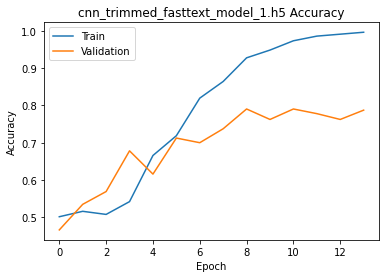

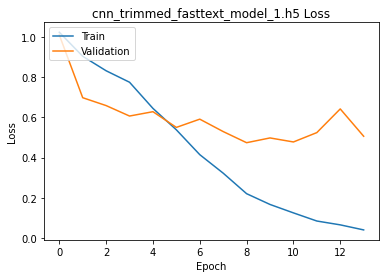

================= Evaluation Report For FastText Model:  1  ================
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       155
           1       0.79      0.83      0.81       165

    accuracy                           0.80       320
   macro avg       0.80      0.80      0.80       320
weighted avg       0.80      0.80      0.80       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 9s 10ms/sample - loss: 0.8936 - acc: 0.5104 - val_loss: 0.6896 - val_acc: 0.5375
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8088 - acc: 0.5271 - val_loss: 0.6541 - val_acc: 0.6562
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.7220 - acc: 0.5844 - val_loss: 0.6232 - val_acc: 0.6781
Epoch 4/100
960/960 [==============================] - 7s 7ms/sample - loss: 0.6043 - acc: 0.6667 - val_loss: 0.5986 - val_acc: 0.6781
Epoch 5/1

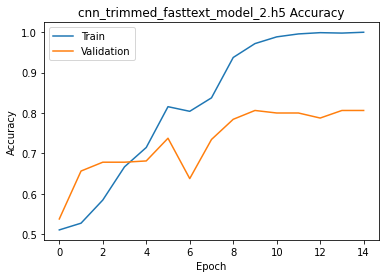

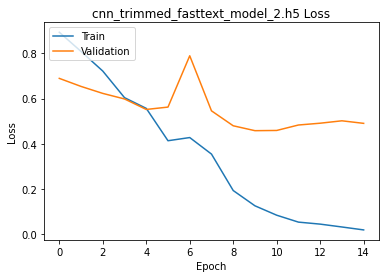

================= Evaluation Report For FastText Model:  2  ================
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       155
           1       0.84      0.79      0.82       165

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.82      0.82      0.82       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 9s 9ms/sample - loss: 0.9476 - acc: 0.5135 - val_loss: 0.7213 - val_acc: 0.5188
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8884 - acc: 0.5063 - val_loss: 0.8375 - val_acc: 0.5000
Epoch 3/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8304 - acc: 0.5167 - val_loss: 0.6719 - val_acc: 0.5688
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.7259 - acc: 0.5917 - val_loss: 0.6388 - val_acc: 0.5938
Epoch 5/10

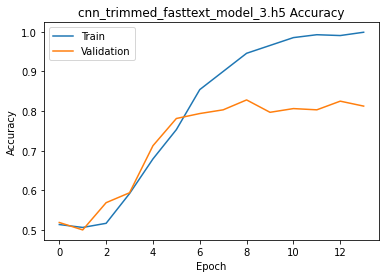

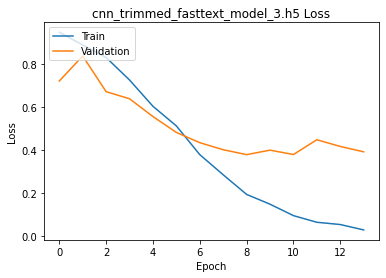

================= Evaluation Report For FastText Model:  3  ================
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       155
           1       0.82      0.82      0.82       165

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.82      0.82      0.82       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 9s 10ms/sample - loss: 1.1992 - acc: 0.4844 - val_loss: 0.8928 - val_acc: 0.5344
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8974 - acc: 0.5135 - val_loss: 0.7260 - val_acc: 0.5406
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8190 - acc: 0.5490 - val_loss: 0.7133 - val_acc: 0.5781
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.7396 - acc: 0.5865 - val_loss: 0.6426 - val_acc: 0.6094
Epoch 5/1

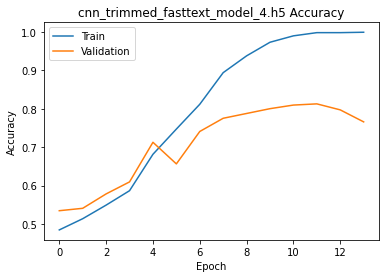

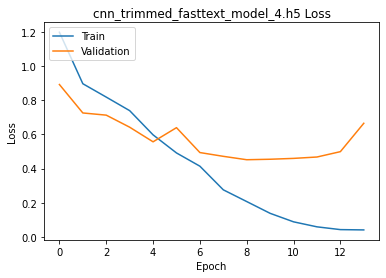

================= Evaluation Report For FastText Model:  4  ================
              precision    recall  f1-score   support

           0       0.92      0.43      0.58       155
           1       0.64      0.96      0.77       165

    accuracy                           0.70       320
   macro avg       0.78      0.69      0.68       320
weighted avg       0.77      0.70      0.68       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 9s 10ms/sample - loss: 1.1347 - acc: 0.4698 - val_loss: 0.9164 - val_acc: 0.4719
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9190 - acc: 0.5052 - val_loss: 0.7249 - val_acc: 0.5219
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8341 - acc: 0.5354 - val_loss: 0.6706 - val_acc: 0.5469
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.7630 - acc: 0.5521 - val_loss: 0.6782 - val_acc: 0.5469
Epoch 5/1

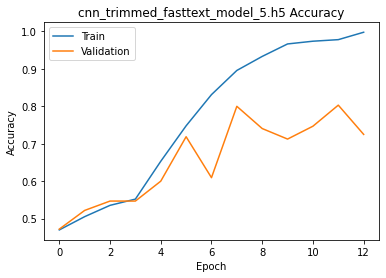

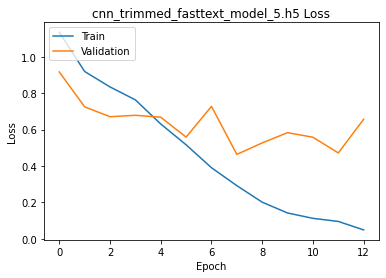

================= Evaluation Report For FastText Model:  5  ================
              precision    recall  f1-score   support

           0       0.88      0.51      0.64       155
           1       0.67      0.93      0.78       165

    accuracy                           0.73       320
   macro avg       0.77      0.72      0.71       320
weighted avg       0.77      0.73      0.71       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 9s 10ms/sample - loss: 0.9102 - acc: 0.4938 - val_loss: 0.6952 - val_acc: 0.5531
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.7941 - acc: 0.5146 - val_loss: 0.7357 - val_acc: 0.5031
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.7797 - acc: 0.5479 - val_loss: 0.8061 - val_acc: 0.5000
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.7418 - acc: 0.5656 - val_loss: 0.5925 - val_acc: 0.7063
Epoch 5/1

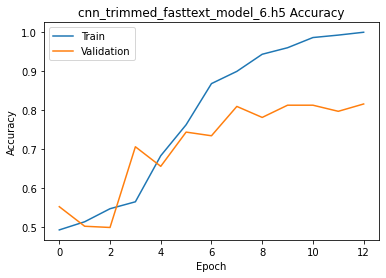

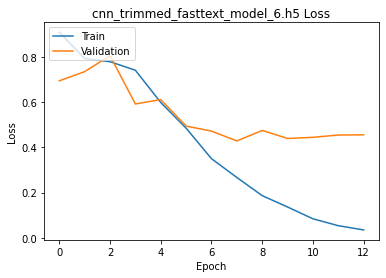

================= Evaluation Report For FastText Model:  6  ================
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       155
           1       0.83      0.82      0.83       165

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.82      0.82      0.82       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 9s 9ms/sample - loss: 0.9128 - acc: 0.4802 - val_loss: 0.6924 - val_acc: 0.5188
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.7670 - acc: 0.5448 - val_loss: 0.6432 - val_acc: 0.6313
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.6866 - acc: 0.6177 - val_loss: 0.6927 - val_acc: 0.5594
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.6495 - acc: 0.6427 - val_loss: 0.5680 - val_acc: 0.6906
Epoch 5/10

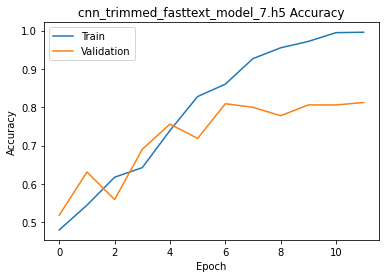

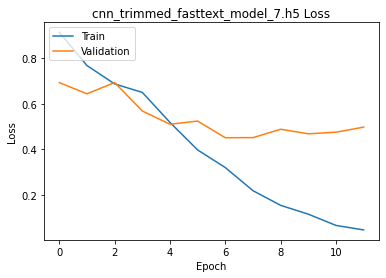

================= Evaluation Report For FastText Model:  7  ================
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       155
           1       0.87      0.70      0.78       165

    accuracy                           0.79       320
   macro avg       0.81      0.80      0.79       320
weighted avg       0.81      0.79      0.79       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 9s 10ms/sample - loss: 1.2747 - acc: 0.4740 - val_loss: 0.6772 - val_acc: 0.5750
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 1.0168 - acc: 0.4938 - val_loss: 0.7391 - val_acc: 0.5500
Epoch 3/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8335 - acc: 0.5542 - val_loss: 0.6951 - val_acc: 0.5594
Epoch 4/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.7825 - acc: 0.5583 - val_loss: 0.6347 - val_acc: 0.6281
Epoch 5/1

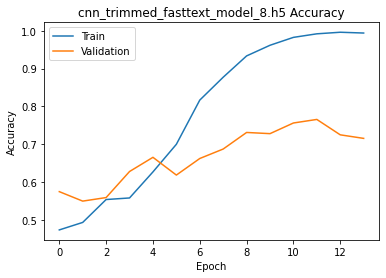

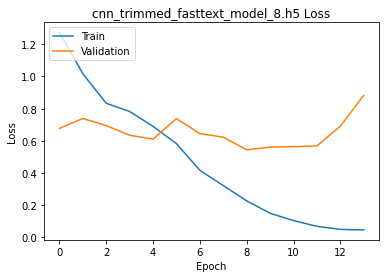

================= Evaluation Report For FastText Model:  8  ================
              precision    recall  f1-score   support

           0       0.91      0.45      0.60       155
           1       0.65      0.96      0.77       165

    accuracy                           0.71       320
   macro avg       0.78      0.70      0.69       320
weighted avg       0.78      0.71      0.69       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 9s 10ms/sample - loss: 1.0363 - acc: 0.5292 - val_loss: 0.8767 - val_acc: 0.5250
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8987 - acc: 0.5365 - val_loss: 0.6663 - val_acc: 0.5813
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9108 - acc: 0.5198 - val_loss: 0.6554 - val_acc: 0.5969
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.7411 - acc: 0.5708 - val_loss: 0.6300 - val_acc: 0.6187
Epoch 5/1

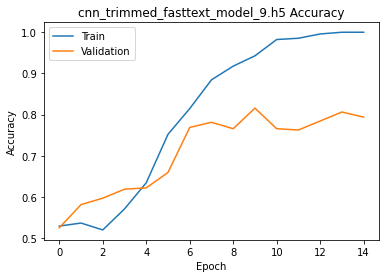

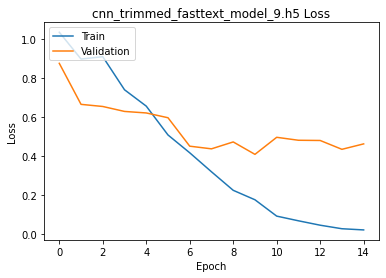

================= Evaluation Report For FastText Model:  9  ================
              precision    recall  f1-score   support

           0       0.87      0.70      0.78       155
           1       0.76      0.90      0.82       165

    accuracy                           0.80       320
   macro avg       0.81      0.80      0.80       320
weighted avg       0.81      0.80      0.80       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 9s 10ms/sample - loss: 1.3830 - acc: 0.4781 - val_loss: 1.0755 - val_acc: 0.4938
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.9786 - acc: 0.5052 - val_loss: 0.9891 - val_acc: 0.4938
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8522 - acc: 0.5281 - val_loss: 0.6903 - val_acc: 0.5125
Epoch 4/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.7790 - acc: 0.5594 - val_loss: 0.6298 - val_acc: 0.6656
Epoch 5/1

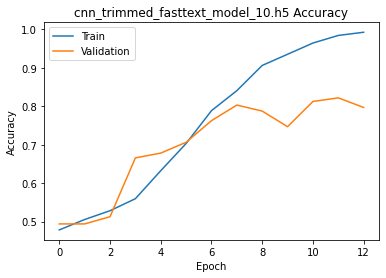

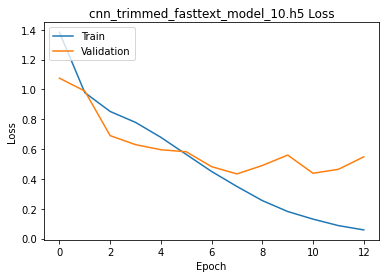

================= Evaluation Report For FastText Model:  10  ================
              precision    recall  f1-score   support

           0       0.87      0.61      0.72       155
           1       0.72      0.92      0.80       165

    accuracy                           0.77       320
   macro avg       0.79      0.76      0.76       320
weighted avg       0.79      0.77      0.76       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 10ms/sample - loss: 0.9699 - acc: 0.4990 - val_loss: 1.0894 - val_acc: 0.4750
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8495 - acc: 0.5260 - val_loss: 0.9465 - val_acc: 0.4750
Epoch 3/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8256 - acc: 0.5281 - val_loss: 0.6351 - val_acc: 0.6375
Epoch 4/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.7458 - acc: 0.5781 - val_loss: 0.7775 - val_acc: 0.4906
Epoch 5

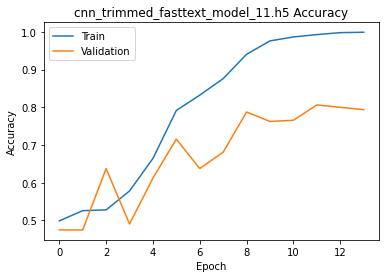

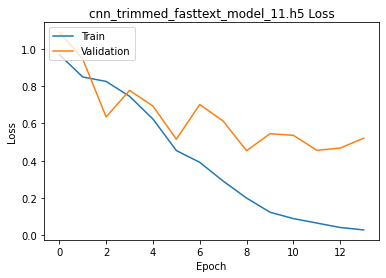

================= Evaluation Report For FastText Model:  11  ================
              precision    recall  f1-score   support

           0       0.88      0.65      0.74       155
           1       0.73      0.92      0.81       165

    accuracy                           0.78       320
   macro avg       0.81      0.78      0.78       320
weighted avg       0.80      0.78      0.78       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 10ms/sample - loss: 0.9552 - acc: 0.4698 - val_loss: 0.7336 - val_acc: 0.4906
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8309 - acc: 0.5500 - val_loss: 0.7072 - val_acc: 0.5688
Epoch 3/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.7859 - acc: 0.5333 - val_loss: 0.6064 - val_acc: 0.6656
Epoch 4/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.6847 - acc: 0.6167 - val_loss: 0.5830 - val_acc: 0.7000
Epoch 5

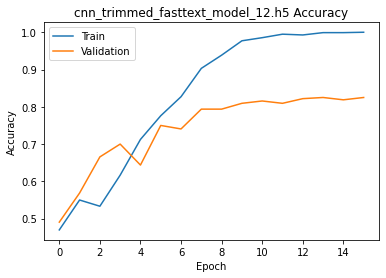

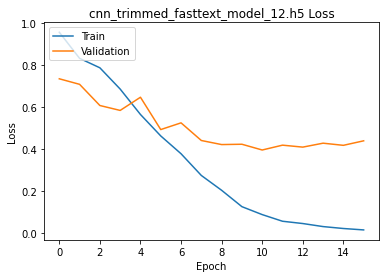

================= Evaluation Report For FastText Model:  12  ================
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       155
           1       0.86      0.78      0.82       165

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.82      0.82      0.82       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 10ms/sample - loss: 1.0393 - acc: 0.4844 - val_loss: 0.6984 - val_acc: 0.5375
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8317 - acc: 0.5312 - val_loss: 0.6671 - val_acc: 0.5969
Epoch 3/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.7575 - acc: 0.5594 - val_loss: 0.6499 - val_acc: 0.5813
Epoch 4/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.6676 - acc: 0.6219 - val_loss: 0.6412 - val_acc: 0.6125
Epoch 5

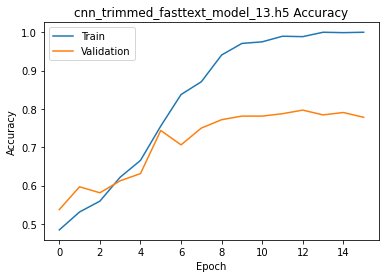

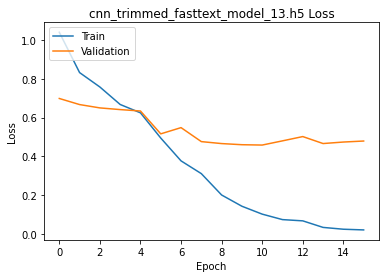

================= Evaluation Report For FastText Model:  13  ================
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       155
           1       0.83      0.82      0.83       165

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.82      0.82      0.82       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 10ms/sample - loss: 1.0474 - acc: 0.5094 - val_loss: 0.7259 - val_acc: 0.5156
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8595 - acc: 0.5333 - val_loss: 1.2131 - val_acc: 0.4844
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8724 - acc: 0.4958 - val_loss: 0.7529 - val_acc: 0.4938
Epoch 4/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8175 - acc: 0.5542 - val_loss: 0.7055 - val_acc: 0.5094
Epoch 5

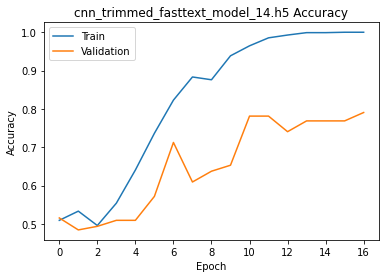

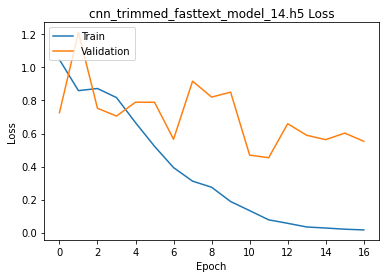

================= Evaluation Report For FastText Model:  14  ================
              precision    recall  f1-score   support

           0       0.84      0.66      0.74       155
           1       0.73      0.88      0.80       165

    accuracy                           0.78       320
   macro avg       0.79      0.77      0.77       320
weighted avg       0.79      0.78      0.77       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 10ms/sample - loss: 0.9999 - acc: 0.4917 - val_loss: 1.1721 - val_acc: 0.5000
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.9353 - acc: 0.5281 - val_loss: 0.7996 - val_acc: 0.5000
Epoch 3/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8628 - acc: 0.5281 - val_loss: 0.6534 - val_acc: 0.6031
Epoch 4/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.7591 - acc: 0.5677 - val_loss: 0.6531 - val_acc: 0.6000
Epoch 5

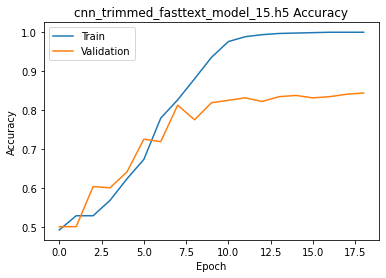

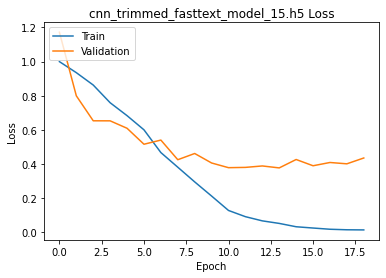

================= Evaluation Report For FastText Model:  15  ================
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       155
           1       0.76      0.88      0.81       165

    accuracy                           0.79       320
   macro avg       0.80      0.79      0.79       320
weighted avg       0.80      0.79      0.79       320



In [24]:
trimmed_word_2_vec_model_file_route = '/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/trimmed_word_embedding_file/trimmed_fasttext_model.pickle'
save_key = 'trimmed_word_2_vec_model'
word_2_vec_model = loadWord2VecModel(trimmed_word_2_vec_model_file_route, save_key)

for i in range(15):    
    model = createCNNModel()

    early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25) 
    history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), batch_size = 64, callbacks = [early_stop])

    predictions = model.predict(X_test)

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('cnn_trimmed_fasttext_model_' + str(i + 1) + '.h5 Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/graphs_and_figures/cnn_trimmed_fasttext_model_' + str(i + 1) + '.h5_Accuracy.png')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('cnn_trimmed_fasttext_model_' + str(i + 1) + '.h5 Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/graphs_and_figures/cnn_trimmed_fasttext_model_' + str(i + 1) + '.h5_Loss.png')
    plt.show()

    print('============================================================================')
    print('================= Evaluation Report For FastText Model: ', (i + 1), ' ================')
    print('============================================================================')
    print(classification_report(np.argmax(y_test, axis = 1), np.argmax(predictions, axis = 1)))

    saveRoute = '/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/trained_model/models/cnn_trimmed_fasttext_model_' + str(i + 1) + '.h5'
    model.save(saveRoute)

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 10ms/sample - loss: 1.0063 - acc: 0.5146 - val_loss: 0.7247 - val_acc: 0.5344
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8854 - acc: 0.5229 - val_loss: 0.6843 - val_acc: 0.5406
Epoch 3/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8378 - acc: 0.5344 - val_loss: 0.6933 - val_acc: 0.5531
Epoch 4/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.7530 - acc: 0.5719 - val_loss: 0.7029 - val_acc: 0.5656
Epoch 5/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.7022 - acc: 0.6375 - val_loss: 0.8481 - val_acc: 0.5469
Epoch 6/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.6231 - acc: 0.6833 - val_loss: 0.5380 - val_acc: 0.7156
Epoch 7/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.4639 - acc: 0.7729 - val_loss: 0.5224 - val_acc: 0.7344
Epoch 8

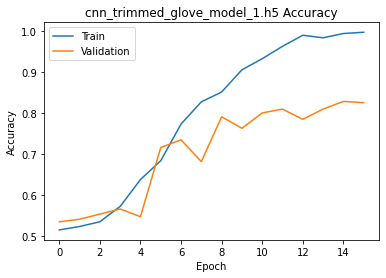

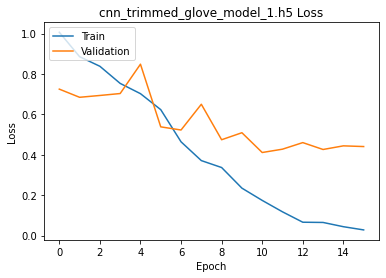

================= Evaluation Report For GloVe Model:  1  ================
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       155
           1       0.83      0.79      0.81       165

    accuracy                           0.81       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.81      0.81      0.81       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 10ms/sample - loss: 1.1041 - acc: 0.5010 - val_loss: 1.2848 - val_acc: 0.5094
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.9764 - acc: 0.5146 - val_loss: 0.7118 - val_acc: 0.5125
Epoch 3/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8869 - acc: 0.5448 - val_loss: 0.7254 - val_acc: 0.5281
Epoch 4/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8273 - acc: 0.5479 - val_loss: 0.6600 - val_acc: 0.6344
Epoch 5/100

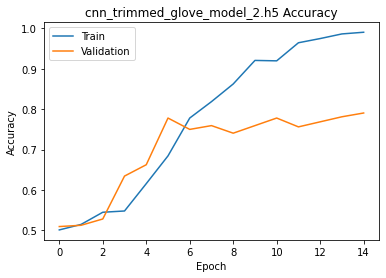

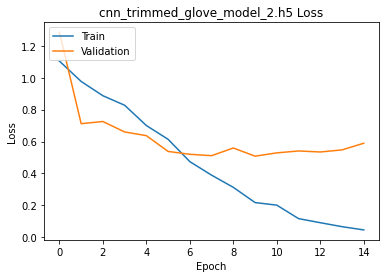

================= Evaluation Report For GloVe Model:  2  ================
              precision    recall  f1-score   support

           0       0.88      0.64      0.74       155
           1       0.73      0.92      0.81       165

    accuracy                           0.78       320
   macro avg       0.80      0.78      0.78       320
weighted avg       0.80      0.78      0.78       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 10ms/sample - loss: 1.1752 - acc: 0.4875 - val_loss: 0.9817 - val_acc: 0.4719
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.9333 - acc: 0.5250 - val_loss: 0.7260 - val_acc: 0.5031
Epoch 3/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.9208 - acc: 0.5000 - val_loss: 1.2827 - val_acc: 0.4719
Epoch 4/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.8635 - acc: 0.5323 - val_loss: 0.6842 - val_acc: 0.5562
Epoch 5/100

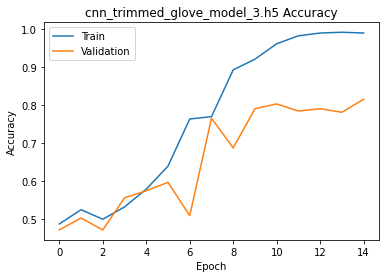

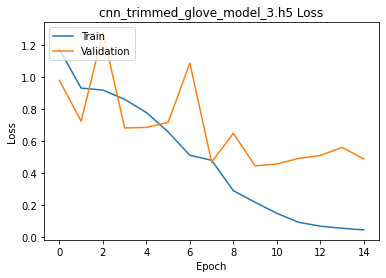

================= Evaluation Report For GloVe Model:  3  ================
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       155
           1       0.74      0.82      0.78       165

    accuracy                           0.76       320
   macro avg       0.76      0.75      0.75       320
weighted avg       0.76      0.76      0.76       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 11ms/sample - loss: 1.0066 - acc: 0.5365 - val_loss: 0.7525 - val_acc: 0.5406
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.9678 - acc: 0.5000 - val_loss: 0.7766 - val_acc: 0.5562
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9227 - acc: 0.5073 - val_loss: 0.7453 - val_acc: 0.5500
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8358 - acc: 0.5656 - val_loss: 0.7386 - val_acc: 0.5344
Epoch 5/100

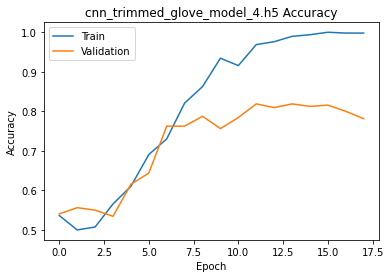

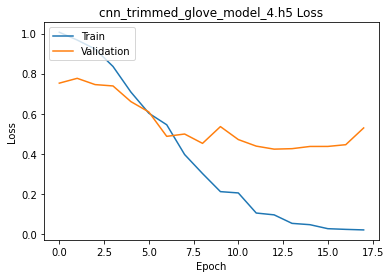

================= Evaluation Report For GloVe Model:  4  ================
              precision    recall  f1-score   support

           0       0.83      0.59      0.69       155
           1       0.70      0.89      0.78       165

    accuracy                           0.74       320
   macro avg       0.77      0.74      0.74       320
weighted avg       0.76      0.74      0.74       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 11ms/sample - loss: 1.0792 - acc: 0.5188 - val_loss: 0.8052 - val_acc: 0.4781
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9806 - acc: 0.5281 - val_loss: 0.6696 - val_acc: 0.5875
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9163 - acc: 0.5448 - val_loss: 0.6502 - val_acc: 0.6438
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8761 - acc: 0.5271 - val_loss: 0.6885 - val_acc: 0.6031
Epoch 5/100

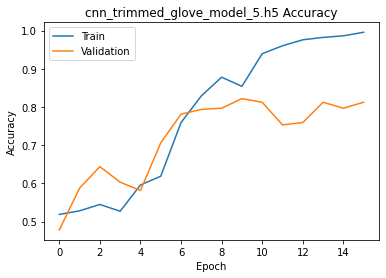

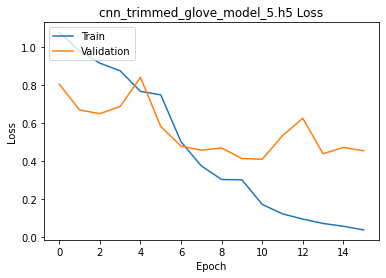

================= Evaluation Report For GloVe Model:  5  ================
              precision    recall  f1-score   support

           0       0.78      0.75      0.77       155
           1       0.77      0.81      0.79       165

    accuracy                           0.78       320
   macro avg       0.78      0.78      0.78       320
weighted avg       0.78      0.78      0.78       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 11ms/sample - loss: 1.0256 - acc: 0.4906 - val_loss: 1.0012 - val_acc: 0.4938
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9463 - acc: 0.5021 - val_loss: 0.6849 - val_acc: 0.5437
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8609 - acc: 0.5521 - val_loss: 0.6730 - val_acc: 0.6094
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.7807 - acc: 0.5719 - val_loss: 0.6511 - val_acc: 0.6281
Epoch 5/100

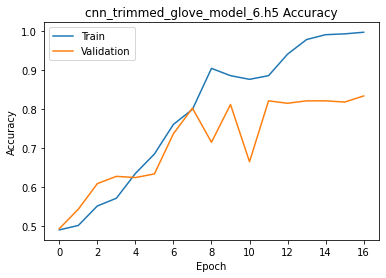

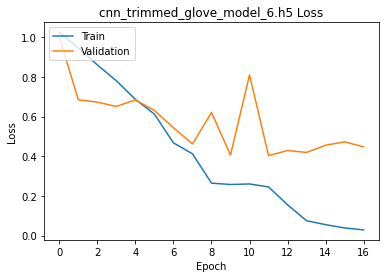

================= Evaluation Report For GloVe Model:  6  ================
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       155
           1       0.81      0.77      0.79       165

    accuracy                           0.79       320
   macro avg       0.79      0.79      0.79       320
weighted avg       0.79      0.79      0.79       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 11ms/sample - loss: 0.9479 - acc: 0.5052 - val_loss: 0.6969 - val_acc: 0.5437
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8368 - acc: 0.5719 - val_loss: 0.7565 - val_acc: 0.5969
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8989 - acc: 0.5510 - val_loss: 0.6896 - val_acc: 0.5312
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8747 - acc: 0.5365 - val_loss: 0.8016 - val_acc: 0.5188
Epoch 5/100

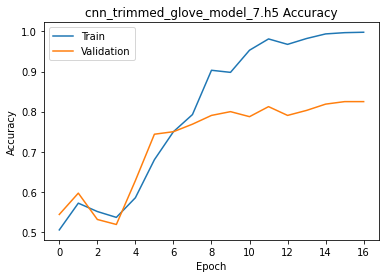

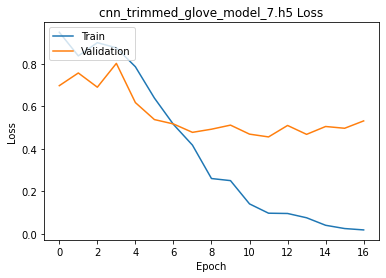

================= Evaluation Report For GloVe Model:  7  ================
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       155
           1       0.79      0.82      0.80       165

    accuracy                           0.79       320
   macro avg       0.79      0.79      0.79       320
weighted avg       0.79      0.79      0.79       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 11ms/sample - loss: 1.1492 - acc: 0.4948 - val_loss: 0.6871 - val_acc: 0.5844
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 1.0224 - acc: 0.5115 - val_loss: 0.8350 - val_acc: 0.5344
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9450 - acc: 0.5135 - val_loss: 0.7865 - val_acc: 0.5094
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.7954 - acc: 0.5917 - val_loss: 0.6675 - val_acc: 0.5844
Epoch 5/100

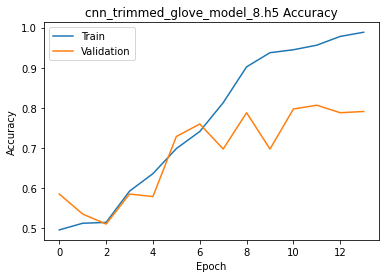

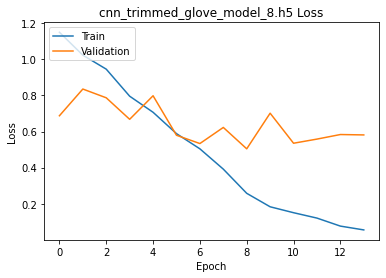

================= Evaluation Report For GloVe Model:  8  ================
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       155
           1       0.81      0.78      0.79       165

    accuracy                           0.79       320
   macro avg       0.79      0.79      0.79       320
weighted avg       0.79      0.79      0.79       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 10s 11ms/sample - loss: 1.2629 - acc: 0.5063 - val_loss: 1.1124 - val_acc: 0.5031
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9540 - acc: 0.5219 - val_loss: 0.7081 - val_acc: 0.5125
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9737 - acc: 0.4823 - val_loss: 0.7891 - val_acc: 0.5031
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9339 - acc: 0.5115 - val_loss: 0.6461 - val_acc: 0.6281
Epoch 5/100

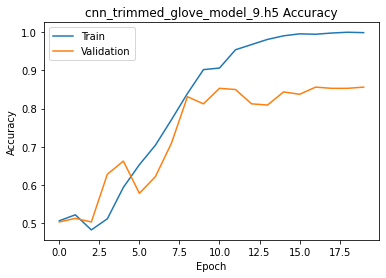

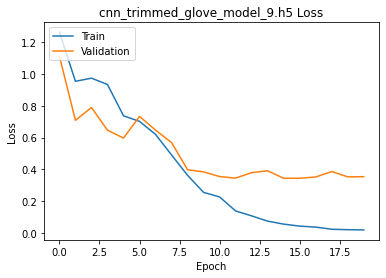

================= Evaluation Report For GloVe Model:  9  ================
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       155
           1       0.77      0.79      0.78       165

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.77      0.77       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 11s 11ms/sample - loss: 1.4274 - acc: 0.4844 - val_loss: 0.9651 - val_acc: 0.5000
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 1.0316 - acc: 0.5229 - val_loss: 0.7484 - val_acc: 0.5000
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 1.0064 - acc: 0.4979 - val_loss: 0.6947 - val_acc: 0.5125
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9643 - acc: 0.5312 - val_loss: 0.8294 - val_acc: 0.5063
Epoch 5/100

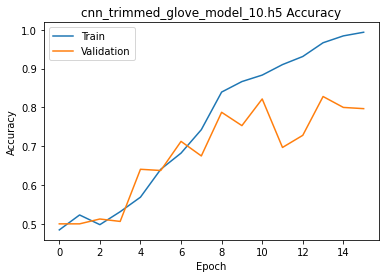

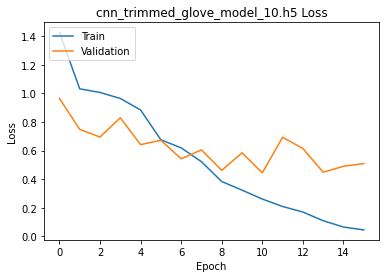

================= Evaluation Report For GloVe Model:  10  ================
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       155
           1       0.73      0.87      0.79       165

    accuracy                           0.77       320
   macro avg       0.78      0.76      0.76       320
weighted avg       0.77      0.77      0.76       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 11s 11ms/sample - loss: 1.2611 - acc: 0.4667 - val_loss: 0.7425 - val_acc: 0.4844
Epoch 2/100
960/960 [==============================] - 6s 6ms/sample - loss: 0.9681 - acc: 0.5177 - val_loss: 0.7329 - val_acc: 0.5063
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9315 - acc: 0.5052 - val_loss: 0.8180 - val_acc: 0.4812
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8001 - acc: 0.5719 - val_loss: 0.7367 - val_acc: 0.5656
Epoch 5/10

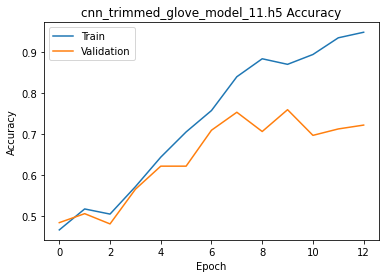

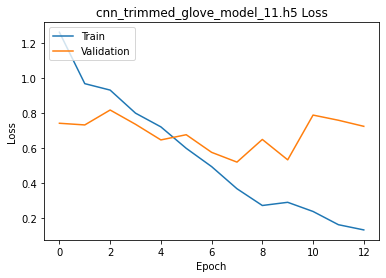

================= Evaluation Report For GloVe Model:  11  ================
              precision    recall  f1-score   support

           0       0.86      0.39      0.53       155
           1       0.62      0.94      0.75       165

    accuracy                           0.67       320
   macro avg       0.74      0.66      0.64       320
weighted avg       0.73      0.67      0.64       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 11s 11ms/sample - loss: 1.2706 - acc: 0.4688 - val_loss: 0.7835 - val_acc: 0.5031
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9302 - acc: 0.5177 - val_loss: 0.7058 - val_acc: 0.5219
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9025 - acc: 0.5292 - val_loss: 0.6623 - val_acc: 0.5875
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8026 - acc: 0.5604 - val_loss: 0.8248 - val_acc: 0.5281
Epoch 5/10

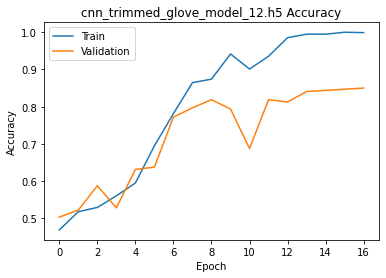

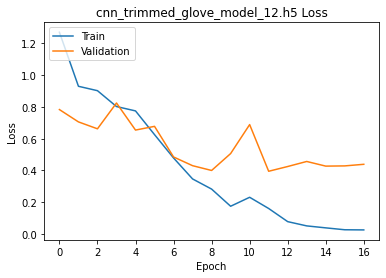

================= Evaluation Report For GloVe Model:  12  ================
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       155
           1       0.76      0.84      0.80       165

    accuracy                           0.78       320
   macro avg       0.78      0.78      0.78       320
weighted avg       0.78      0.78      0.78       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 11s 11ms/sample - loss: 0.9933 - acc: 0.5188 - val_loss: 0.8488 - val_acc: 0.5219
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8580 - acc: 0.5375 - val_loss: 0.6649 - val_acc: 0.6250
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.7657 - acc: 0.5885 - val_loss: 0.6367 - val_acc: 0.6562
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.6701 - acc: 0.6438 - val_loss: 0.6090 - val_acc: 0.6875
Epoch 5/10

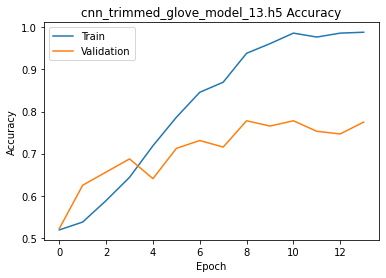

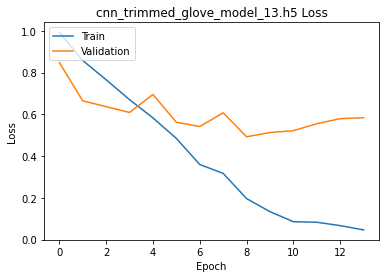

================= Evaluation Report For GloVe Model:  13  ================
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       155
           1       0.76      0.78      0.77       165

    accuracy                           0.76       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.76      0.76      0.76       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 11s 12ms/sample - loss: 1.1438 - acc: 0.4792 - val_loss: 0.7058 - val_acc: 0.5250
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9446 - acc: 0.4938 - val_loss: 0.7124 - val_acc: 0.5312
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8867 - acc: 0.5437 - val_loss: 0.7100 - val_acc: 0.5437
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.7988 - acc: 0.5656 - val_loss: 0.7557 - val_acc: 0.5531
Epoch 5/10

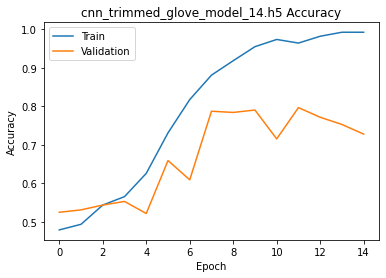

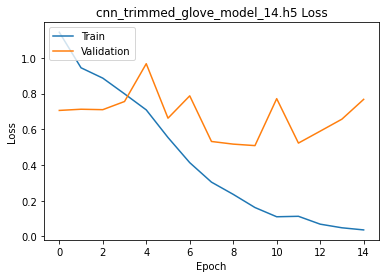

================= Evaluation Report For GloVe Model:  14  ================
              precision    recall  f1-score   support

           0       0.85      0.58      0.69       155
           1       0.70      0.90      0.79       165

    accuracy                           0.75       320
   macro avg       0.77      0.74      0.74       320
weighted avg       0.77      0.75      0.74       320

Train on 960 samples, validate on 320 samples
Epoch 1/100
960/960 [==============================] - 11s 12ms/sample - loss: 1.0947 - acc: 0.5073 - val_loss: 0.7775 - val_acc: 0.5031
Epoch 2/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9547 - acc: 0.4917 - val_loss: 0.6888 - val_acc: 0.5656
Epoch 3/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.9089 - acc: 0.5177 - val_loss: 0.6644 - val_acc: 0.5844
Epoch 4/100
960/960 [==============================] - 6s 7ms/sample - loss: 0.8685 - acc: 0.5333 - val_loss: 0.6377 - val_acc: 0.6313
Epoch 5/10

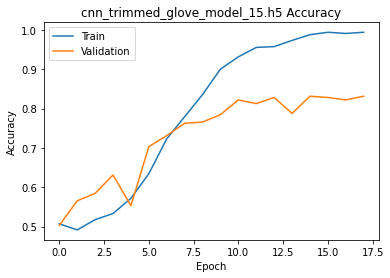

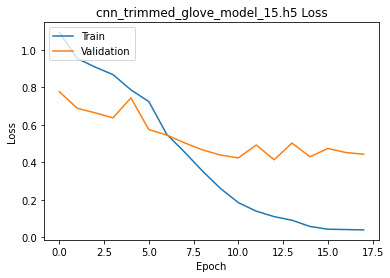

================= Evaluation Report For GloVe Model:  15  ================
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       155
           1       0.82      0.78      0.80       165

    accuracy                           0.80       320
   macro avg       0.80      0.80      0.80       320
weighted avg       0.80      0.80      0.80       320



In [25]:
trimmed_word_2_vec_model_file_route = '/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/trimmed_word_embedding_file/trimmed_glove_model.pickle'
save_key = 'trimmed_glove_model'
word_2_vec_model = loadWord2VecModel(trimmed_word_2_vec_model_file_route, save_key)

for i in range(15):    
    model = createCNNModel()

    early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25) 
    history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), batch_size = 64, callbacks = [early_stop])

    predictions = model.predict(X_test)

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('cnn_trimmed_glove_model_' + str(i + 1) + '.h5 Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/graphs_and_figures/cnn_trimmed_glove_model_' + str(i + 1) + '.h5_Accuracy.png')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('cnn_trimmed_glove_model_' + str(i + 1) + '.h5 Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/graphs_and_figures/cnn_trimmed_glove_model_' + str(i + 1) + '.h5_Loss.png')
    plt.show()

    print('=========================================================================')
    print('================= Evaluation Report For GloVe Model: ', (i + 1), ' ================')
    print('=========================================================================')
    print(classification_report(np.argmax(y_test, axis = 1), np.argmax(predictions, axis = 1)))

    saveRoute = '/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/trained_model/models/cnn_trimmed_glove_model_' + str(i + 1) + '.h5'
    model.save(saveRoute)

In [0]:
pickle_file_route = '/content/drive/My Drive/Colab Notebooks/Deceptive Opinion Spam CNN Committee/trained_model/test_data/test_data.pickle'
save_data = {
    'X_test': X_test,
    'y_test': y_test
}

saveDataUsingPickle(pickle_file_route, save_data)